In [166]:
import torch
import torch.nn as nn
import numpy as np

First, we define the Neural Network architecture we use for regression. It is a Feedforward NN with 1 hidden layer and ReLu activation function.

In [167]:
class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.hl1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.output_layer = torch.nn.Linear(self.hidden_size, 1)
            
        def forward(self, x):
            hidden = self.hl1(x)
            relu = self.relu(hidden)
            output = self.output_layer(relu)
            return output

Next, we create our artificial data. We create data tuples $(x_i,y_i)$, $i=1,...,n$ where the targets $y_i = f(x_i) + \varepsilon$ are noisy realizations of some function $f$ of $x$. Our goal is to recover $f$ with the Neural Network.

Feel free to use any of the provided functions or to define your own.

In [168]:
def create_toy_data(func, n=1000, std=.1, domain=[0., 1.]):
    # x = torch.linspace(domain[0], domain[1], n)
    x = (domain[1]-domain[0]) * torch.rand((n,)) + domain[0]
    t = func(x) + torch.normal(mean=torch.zeros_like(x),std=std*torch.ones_like(x))
    return x, t

def sinusoidal(x):
    return torch.sin(2 * np.pi * x)

def square(x):
    return torch.square(x)

def abs(x):
    return torch.abs(x)

def heavyside(x):
    return 0.5 * (torch.sign(x) + 1)

def exp(x):
    return torch.exp(x)

function = sinusoidal
domain = [-1., 1.]
n = 50

# Define data for training
data, target = create_toy_data(function, n=n, std=.1, domain=domain)
data = data[:,None]

# Define separate data set for testing the model once training is finished
test_data, test_target = create_toy_data(function, n=n, std=.0, domain=domain)
test_data = test_data[:,None]

With real data, $f$ is of course unknown and usualy not a "nice" mathematical function like the sine. These examples serve as a showcase for the suitability as well as the limitations of simple Neural Networks.

We initialize the model, the loss to minimize, and the optimizer (we use stochastic gradient descend).

The mean square error (MSE) loss we minimize is given by 
$$E(\mathbf{w}) =  \frac{1}{n}\sum_{i=1}^{n} |y_i - NN(\mathbf{w})(x_i)|^2,$$
where $NN(\mathbf{w})$ is the forward pass of the Neural Network with parameters $\mathbf{w}$.

In [169]:
model = Feedforward(1,20)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

Evaluate the model on the test data set before training

In [170]:
model.eval()
pred = model(test_data)
before_train = criterion(pred.squeeze(), test_target)
print('Test loss before training' , before_train.item())

Test loss before training 0.5575512051582336


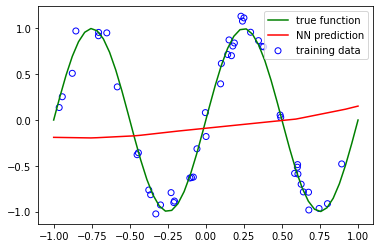

In [171]:
from matplotlib import pyplot as plt

x = torch.linspace(domain[0],domain[1],n)[:,None]
y = model(x).detach().numpy()

plt.scatter(data, target, facecolor="none", edgecolor="b", color="blue", label="training data")
plt.plot(x, function(x), color="g", label="true function")
plt.plot(x, y, color="r", label="NN prediction")
plt.legend()
plt.show()

Execute the training loop.

In [172]:
model.train()
epoch = 5000
for epoch in range(epoch):    
    optimizer.zero_grad()      
    pred = model(data)   # get predictions NN(w)(x_i) of the current model on the data
    loss = criterion(pred.squeeze(), target) # get MSE loss sum_i^n |NN(w)(x_i) - y_i|^2/n
   
    # print('Epoch {}: train loss: {}'.format(epoch, loss.item()))    
    loss.backward()      # compute gradients 
    optimizer.step()     # do a gradient descend step

And evauate the model again after training

In [173]:
model.eval()
pred = model(test_data)
after_train = criterion(pred.squeeze(), test_target)
print('Test loss after training' , after_train.item())

Test loss after training 0.15667542815208435


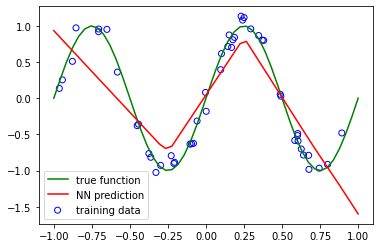

In [174]:
x = torch.linspace(domain[0],domain[1],n)[:,None]
y = model(x).detach().numpy()

plt.scatter(data, target, facecolor="none", edgecolor="b", color="blue", label="training data")
plt.plot(x, function(x), color="g", label="true function")
plt.plot(x, y, color="r", label="NN prediction")
plt.legend()
plt.show()

The result is obviously not convincing. Feel free to change the architecture of the NN (maybe the net is too shallow?) and the parameters of the training loop to improve accuracy.